In [1]:
from drn_interactions.spikes import SpikesHandler, SpikesHandlerMulti
from drn_interactions.load import load_derived_generic, get_fig_dir, load_events
from drn_interactions.transforms import align_to_data_by
from drn_interactions.spikes import bin_spikes


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import NMF, PCA
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import clone
from sklearn.metrics.pairwise import pairwise_distances

import umap
import umap.plot
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from binit.bin import which_bin

import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

class LongTimescaleDecoder:
    def __init__(self, sh, estimator, cv=None, scoring="f1_macro", nboot=75, filter_active=True):
        self.df = sh.binned_piv.copy()
        self.df["state"] = np.where(self.df.index < 0, "pre", np.where(self.df.index < 600, "base_shock", "post_base_shock"))
        self.filter_active = filter_active
        if self.filter_active:
            self.df = self._filter_active(self.df.copy())
        self.nboot = nboot
        self.estimator = estimator
        self.cv = cv if cv is not None else {}
        self.scoring = scoring
    
    def get_real_scores(self):
        df1 = self.df.copy()
        state = df1.pop("state")
        le = LabelEncoder()
        y = le.fit_transform(state)
        X = df1.values
        self.scores_ = cross_val_score(
            self.estimator, 
            X, 
            y, 
            cv=self.cv, 
            scoring=self.scoring
            )
        return self.scores_
    
    def get_unit_scores(self):
        df1 = self.df.copy()
        state = df1.pop("state")
        le = LabelEncoder()
        y = le.fit_transform(state)
        X = df1.values
        out = {}
        for i, n in enumerate(df1.columns):
            out[n] = cross_val_score(
                self.estimator, 
                X[:, i].reshape(-1, 1), 
                y, 
                cv=self.cv, 
                scoring=self.scoring
            )
        return out

    
    def get_bootstrap_scores(self):
        reps = []
        for _ in tqdm(range(self.nboot)):
            X, y = self._shuffle(self.df)
            le = LabelEncoder()
            y = le.fit_transform(y)
            reps.append(cross_val_score(
                clone(self.estimator), 
                X, 
                y, 
                cv=self.cv, 
                scoring=self.scoring
            ))
        return np.vstack(reps)

    
    @staticmethod
    def _filter_active(df):
        idx = np.argwhere((df.sum(axis=1) > 5).values).ravel()
        return df.iloc[idx]
    
    @staticmethod
    def _shuffle(df):
        df1 = df.copy()
        y = df1.pop("state")
        X = df1.apply(np.random.permutation).values
        return X, y


c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
def long_timescale_decode(
    sessions,
    estimator,
    cv=None,
    t_start = -600,
    t_stop = 1200,
    bin_size = 1,
    nboot = 75,
    ):
    pop_frames = []
    unit_frames = []
    for session in sessions:
        print(session)
        sh = SpikesHandlerMulti(
            block=["base_shock", "post_base_shock"], 
            bin_width=bin_size, 
            session_names=[session],
            t_start=t_start, 
            t_stop=t_stop
        )
        decoder = LongTimescaleDecoder(
            sh, cv=cv, estimator=estimator, nboot=nboot
        )
        true = np.mean(decoder.get_real_scores())
        reps = decoder.get_bootstrap_scores()
        
        shuffle = np.mean(reps, axis=1).mean()
        pop_frames.append(pd.DataFrame({"true": true, "shuffle": shuffle, "session_name": session},
        index=[0]))
        unit_scores = decoder.get_unit_scores()
        unit_frame = pd.DataFrame(unit_scores).mean().to_frame("F1 Score").reset_index().rename(columns=dict(index="neuron_id"))
        unit_frames.append(unit_frame)

    return pd.concat(pop_frames).reset_index(drop=True), pd.concat(unit_frames).reset_index(drop=True)

In [4]:
outdir = get_fig_dir() / "base_shock"
outdir.mkdir(exist_ok=True, parents=True)

In [5]:
outdir = get_fig_dir() / "base_shock"
outdir.mkdir(exist_ok=True, parents=True)
neurons = (
    load_derived_generic("burst_features.csv")
    .merge(load_derived_generic("clusters.csv"))
)
events = load_events(block_name="base_shock")

sessions = events.merge(neurons).session_name.unique()

In [143]:
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV()
)
cv = StratifiedKFold(shuffle=True)

pop, unit = long_timescale_decode(
    sessions=sessions,
    estimator=pipe, 
    cv=cv, 
    bin_size=1,
    nboot=1,
    )

hamilton_04


c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

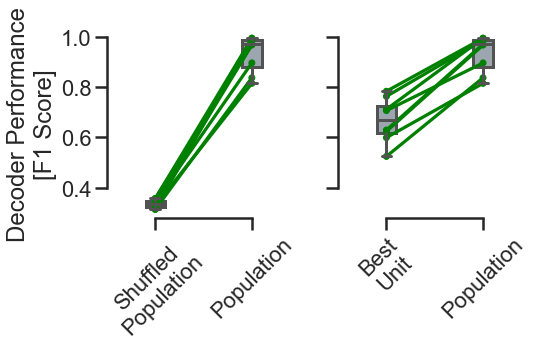

In [ ]:
sns.set_theme(context="poster", style="ticks")
df = (
    unit.merge(neurons)
    .groupby("session_name")["F1 Score"]
    .max()
    .to_frame("best_neuron")
    .reset_index()
    .merge(pop)
)

fig, ax = plt.subplots(ncols=2, figsize=(8, 5), sharey=True)

ax0 = ax[0]
df1 =  pop.melt(id_vars="session_name")

pg.plot_paired(data=df1, dv='value', within='variable',
               subject='session_name', ax=ax0, boxplot=True,
            #    colors=['grey', 'grey', 'grey']
               )
ax0.set_xlabel(None)
ax0.set_ylabel("Decoder Performance\n[F1 Score]")
ax0.set_xticklabels(["Shuffled\nPopulation", "Population"], rotation = 45)


ax1 = ax[1]
df1 =  df.drop("shuffle", axis=1).melt(id_vars="session_name")

pg.plot_paired(data=df1, dv='value', within='variable',
               subject='session_name', ax=ax1, boxplot=True,
            #    colors=['grey', 'grey', 'grey']
               )
ax1.set_xlabel(None)
ax1.set_ylabel("Decoder Performance\n[F1 Score]")
ax1.set_xticklabels(["Best\nUnit", "Population"], rotation = 45)

plt.tight_layout()
# plt.savefig(outdir / "long timescale decoder compare.png", dpi=300, transparent=True)

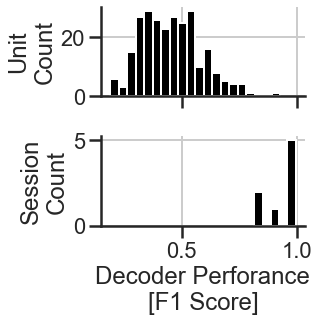

In [ ]:
_, ax = plt.subplots(figsize=(5, 5), nrows=2, sharex=True)
unit["F1 Score"].hist(color="black", ax=ax[0], bins=20)
ax[0].set_ylabel("Unit\nCount", rotation=90)

pop["true"].hist(color="black", ax=ax[1], bins=5)
ax[1].set_ylabel("Session\nCount")

ax[1].set_xlabel("Decoder Perforance\n[F1 Score]")
sns.despine()
plt.tight_layout()

# plt.savefig(outdir / "Slow Timescale Decoding Counts.png", dpi=300, transparent=True)

In [ ]:
sh = SpikesHandlerMulti(
    block=["base_shock", "post_base_shock"], 
    bin_width=1, 
    session_names=[sessions[2]],
    t_start=-600, 
    t_stop=1200
)

<AxesSubplot:xlabel='bin', ylabel='neuron_id'>

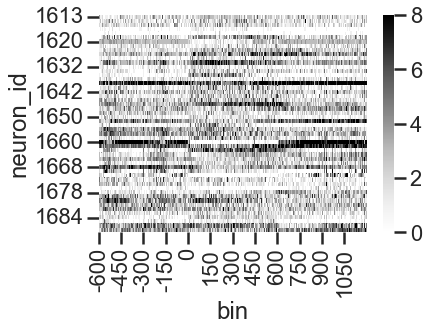

In [57]:
# sns.heatmap(sh.binned_piv.transpose(), robust=True, cmap="Greys")

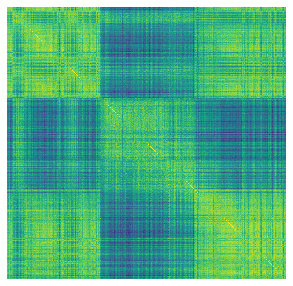

In [85]:
_, ax  = plt.subplots(figsize=(5, 5))

X = 1 - pairwise_distances(sh.binned_piv, metric="cosine")

X = X / np.max(X)

sns.heatmap(X, cmap="viridis", vmax=1, cbar=False, 
xticklabels=[], yticklabels=[], ax=ax)
# plt.savefig(outdir / "long timescale similarity.png", dpi=300, transparent=True)

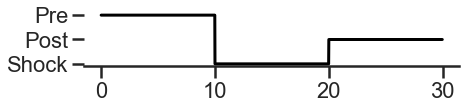

In [84]:
_, ax = plt.subplots(figsize=(7, 2))

state = np.where(df.index < 0, "pre", np.where(df.index < 600, "base_shock", "post_base_shock"))

y = LabelEncoder().fit_transform(state)

ax.plot(np.arange(len(y)) / 60 ,y, color="black")

ax.set_yticks([0, 1, 2])
# ax.set_xticks([, 0])
ax.set_yticklabels(["Shock", "Post", "Pre"])

sns.despine(left=True)
plt.tight_layout()
# plt.savefig(outdir / "long timescale state.png", dpi=300, transparent=True)

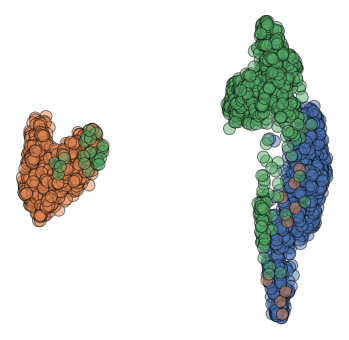

In [72]:

df = sh.binned_piv
X = sh.binned_piv.values
# X = TfidfTransformer().fit_transform(df.values)


state = np.where(df.index < 0, "pre", np.where(df.index < 600, "base_shock", "post_base_shock"))

y = LabelEncoder().fit_transform(state)
# y = np.where(y == "sw", 1, 0)

mod = umap.UMAP().fit(X)
df1 = pd.DataFrame(mod.embedding_, columns=["d1", "d2"], index=df.index).reset_index()
df1["state"] = state

# sns.set_theme(context="poster", style="ticks")
_, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df1, x="d1", y="d2", hue="state", alpha=0.5, ax=ax, edgecolor="black")
ax.axis("off")
ax.legend().remove()

# plt.savefig(outdir / "longtimescale UMAP_bpre_oshock.png", transparent=True, dpi=500)



In [13]:
from drn_interactions.load import load_spikes, load_events, get_fig_dir, load_derived_generic
from spiketimes.df.surrogates import shuffled_isi_spiketrains_by
from scipy.stats import zscore
from drn_interactions.decode import OffsetDecoder
from drn_interactions.transforms import align_to_data_by
from binit.bin import which_bin
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import NMF, PCA
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import clone
from sklearn.metrics.pairwise import pairwise_distances

import umap
import umap.plot
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from binit.bin import which_bin

import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns




outdir = get_fig_dir() / "base_shock"
outdir.mkdir(exist_ok=True, parents=True)
neurons = (
    load_derived_generic("burst_features.csv")
    .merge(load_derived_generic("clusters.csv"))
)
neurons_sub = neurons[["neuron_id", "session_name"]]
df_spikes = load_spikes("base_shock").merge(neurons_sub)
df_events = load_events("base_shock")

sessions = neurons_sub.merge(df_events[["session_name"]]).session_name.unique()

In [19]:
def get_aligned(df_spikes, df_events,):
    df = align_to_data_by(
        df_spikes, 
        df_events,
        time_before_event=0.5,
        time_after_event=1.5,
        df_data_cell_col="neuron_id",
        df_data_group_col="session_name",
        df_events_group_colname="session_name",
        df_events_timestamp_col="event_s",
        df_data_time_col="spiketimes"
    )
    bins = np.arange(-0.5, 1.5, 0.1)
    df["bin"] = np.round(which_bin(df["aligned"].values, bins), 2)
    df = df.groupby(["neuron_id", "event", "bin"]).apply(len).to_frame("counts").reset_index()
    return df.pivot(index=["event", "bin"], columns="neuron_id", values="counts").fillna(0)

def offset_decode(df_spikes, df_events, sessions, estimator, cv, scoring="f1_macro"):
    neurons_sub = df_spikes[["neuron_id", "session_name"]].drop_duplicates()
    out = []
    for session in tqdm(sessions):
        shuffled = shuffled_isi_spiketrains_by(df_spikes, by_col="neuron_id").merge(neurons_sub)
        spikes_true = get_aligned(
            df_spikes.query(f"session_name == '{session}'"),
            df_events
            )
        spikes_fake = get_aligned(
            shuffled.query(f"session_name == '{session}'"),
            df_events
        )
        decoder = OffsetDecoder(estimator=clone(estimator), cv=cv, scoring=scoring)
        res = decoder.fit_models([(spikes_true, spikes_fake)])
        out.append(res.assign(session_name = session))
    return out

In [20]:
cv = StratifiedKFold(shuffle=True)
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV()
)

res = offset_decode(df_spikes, df_events, sessions, estimator=pipe, cv=cv, scoring="f1_macro")


  0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

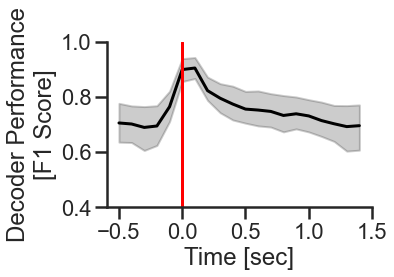

In [93]:
sns.set_theme(context="poster", style="ticks")

df_res = pd.concat(res)
_, ax = plt.subplots(figsize=(6, 4s))

(
    df_res
    .groupby(["offset", "session_name"])["f1score"]
    .mean()
    .to_frame("f1score")
    .reset_index()
    .pipe((sns.lineplot, "data"), x="offset", y="f1score", color="black", ax=ax)
)
ax.axvline(0, color="red")
ax.set_ylim(0.4, 1)
ax.set_ylabel("Decoder Performance\n[F1 Score]")

ax.set_xlabel("Time [sec]")
ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])


plt.tight_layout()
sns.despine()
plt.savefig(outdir / "Short timescale aligned.png", dpi=300, transparent=True)

In [75]:

session = sessions[1]
df =  get_aligned(
            df_spikes.query(f"session_name == '{session}'"),
            df_events
            )

In [76]:
df1 = df.reset_index().groupby("bin").mean().drop("event", axis=1).apply(zscore)


mod = umap.UMAP().fit(X)
df2 = pd.DataFrame(mod.embedding_, columns=["d1", "d2"], index=df1.index).reset_index()


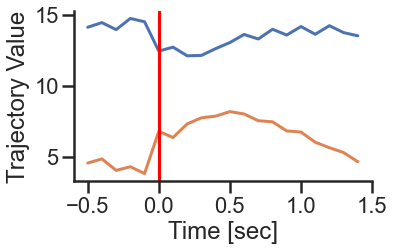

In [91]:
sns.set_theme(context="poster", style="ticks")

_, ax = plt.subplots(figsize=(6, 4))

ax.plot(df2["bin"], df2["d1"], label="UMAP1")
ax.plot(df2["bin"],  df2["d2"], label="UMAP2")
# ax.legend()
sns.despine()
ax.axvline(0, color="red")
ax.set_ylabel("Trajectory Value")
ax.set_xlabel("Time [sec]")
ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
plt.tight_layout()
plt.savefig(outdir / "UMAP aligned.png", dpi=300, transparent=True)

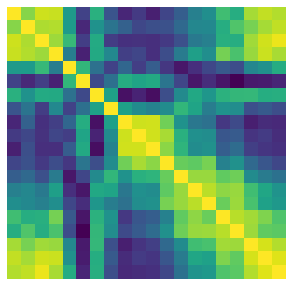

In [89]:
_, ax  = plt.subplots(figsize=(5, 5))

X = 1 - pairwise_distances(df1, metric="cosine")

X = X / np.max(X)

sns.heatmap(X, cmap="viridis", vmax=1, cbar=False, 
xticklabels=[], yticklabels=[], ax=ax)
# plt.savefig(outdir / "Similarity Map.png", dpi=300, transparent=True)